In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from pathlib import Path
import tqdm
import sys
import seaborn as sns
import scipy.stats
import os
import joblib
import subprocess
import polars as pl
import io
import glob
import statsmodels.stats.proportion

pd.set_option('display.max_rows', 1000)


In [21]:
sys.path.append(str(Path(os.getcwd()).parent))
from src import liftover, annotate, diagnostics, inference
from src.IDs import *

In [22]:
rahbari_df = pl.read_csv("/nfs/users/nfs_r/rs42/rs42/git/sperm/configs/Rahbari.tsv", separator='\t')

In [5]:
output_path = Path("/lustre/scratch122/tol/projects/sperm/results/Rahbari_20250212")

ann_snps_df = pl.concat([
    pl.scan_parquet(glob.glob(str(
        output_path / f"read_analysis/{sample_set}/{sample_id}/*/*/annotated_0.95_high_confidence_snps.parquet"
    ))).with_columns(sample_id=pl.lit(sample_id))
    for sample_id, sample_set in tqdm.tqdm(rahbari_df.select("sample_id", "sample_set").unique().iter_rows())
])
    
ann_snps_df = diagnostics.add_high_quality_annotation(
    ann_snps_df,
    input_column_prefix = "is_high_conf",
    output_column_prefix = "is_high_quality_test",
    phased_coverage_min = 3,
    allele_coverage_min = 3,
    balance_p_value_threshold = 0,
    unassigned_reads_max = 10000,
)

ann_snps_df = (ann_snps_df
    .filter(pl.col("is_high_quality_test_snp"))
)

9it [00:08,  1.01it/s]


In [6]:
coverage_hist = (ann_snps_df
    .group_by("sample_id", "hap1_certainty_0.95_coverage", "hap2_certainty_0.95_coverage")
    .len()
    .collect(streaming=True)
)

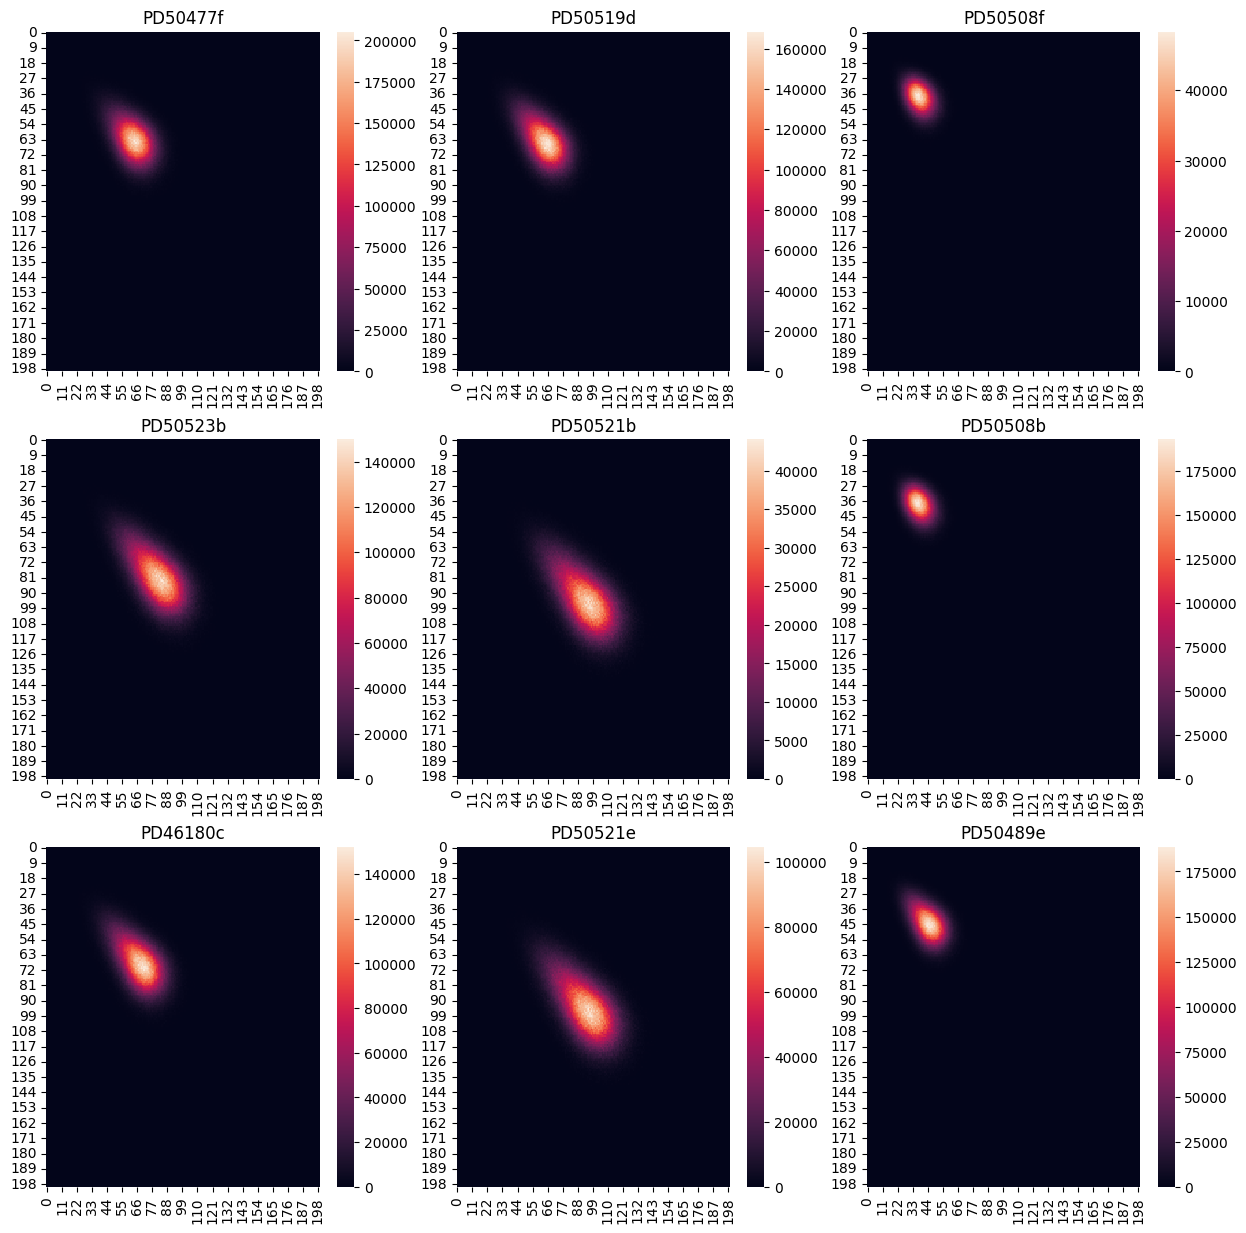

In [7]:
fig, axs = plt.subplots(3,3, figsize=(15, 15));

for sample_id, ax in zip(rahbari_sample_ids, axs.ravel()):
    sub = coverage_hist.filter(pl.col("sample_id") == sample_id)
    A = np.zeros((200, 200))
    A[
        sub["hap1_certainty_0.95_coverage"], 
        sub["hap2_certainty_0.95_coverage"],
    ] = sub["len"]
    sns.heatmap(A[:200,:200], ax=ax);
    ax.set_title(sample_id)


    

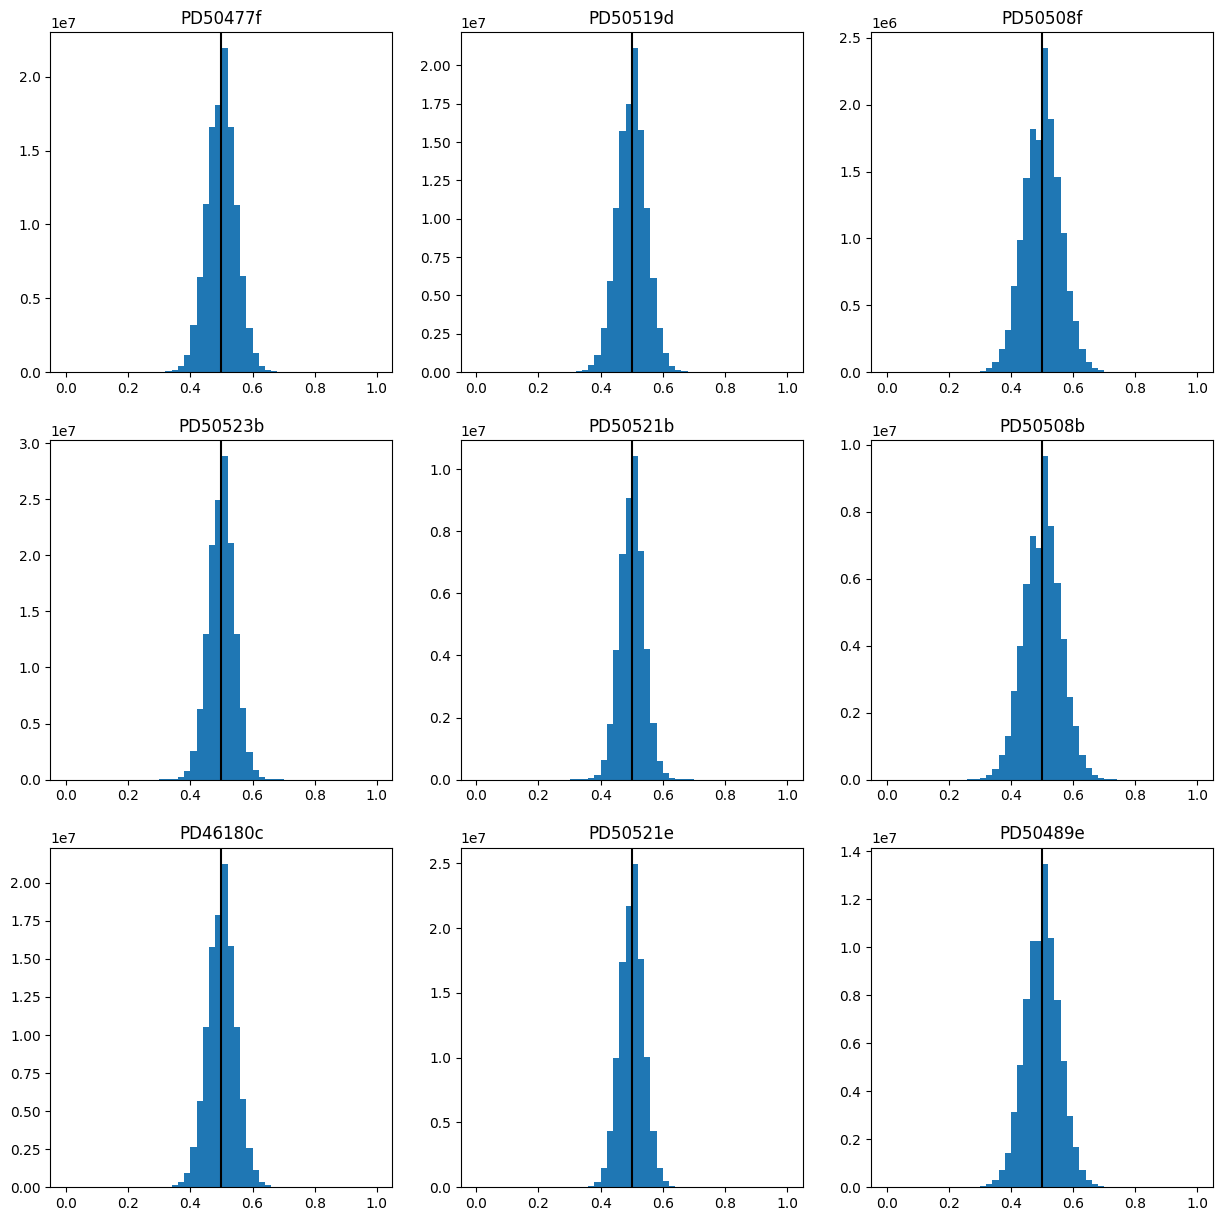

In [8]:
fig, axs = plt.subplots(3,3, figsize=(15, 15));

for sample_id, ax in zip(rahbari_sample_ids, axs.ravel()):
    sub = coverage_hist.filter(pl.col("sample_id") == sample_id)
    A = np.zeros((200, 200))
    A[
        sub["hap1_certainty_0.95_coverage"], 
        sub["hap2_certainty_0.95_coverage"],
    ] = sub["len"]
    x = []
    w = []
    for i in range(200): 
        for j in range(200):
            if i == 0 and j == 0:
                continue
            x.append((i/(i+j)))
            w.append(A[i,j])

    ax.hist(
        x=x, weights=w, bins=50,
    );
    ax.axvline(0.5, color="black");
    ax.set_title(sample_id)


    

In [9]:
%%time
hist_unassigned = (
    ann_snps_df
    .filter((pl.col("hap1_total_coverage") == pl.col("hap2_total_coverage")))
    .with_columns(
         unassigned_reads = (pl.col("hap1_total_coverage") - pl.col("hap1_certainty_0.95_coverage") - pl.col("hap2_certainty_0.95_coverage"))
    )
    .group_by("sample_id", "unassigned_reads")
    .len()
    .collect(streaming=True)
)

CPU times: user 8min 19s, sys: 2min, total: 10min 20s
Wall time: 8min 26s


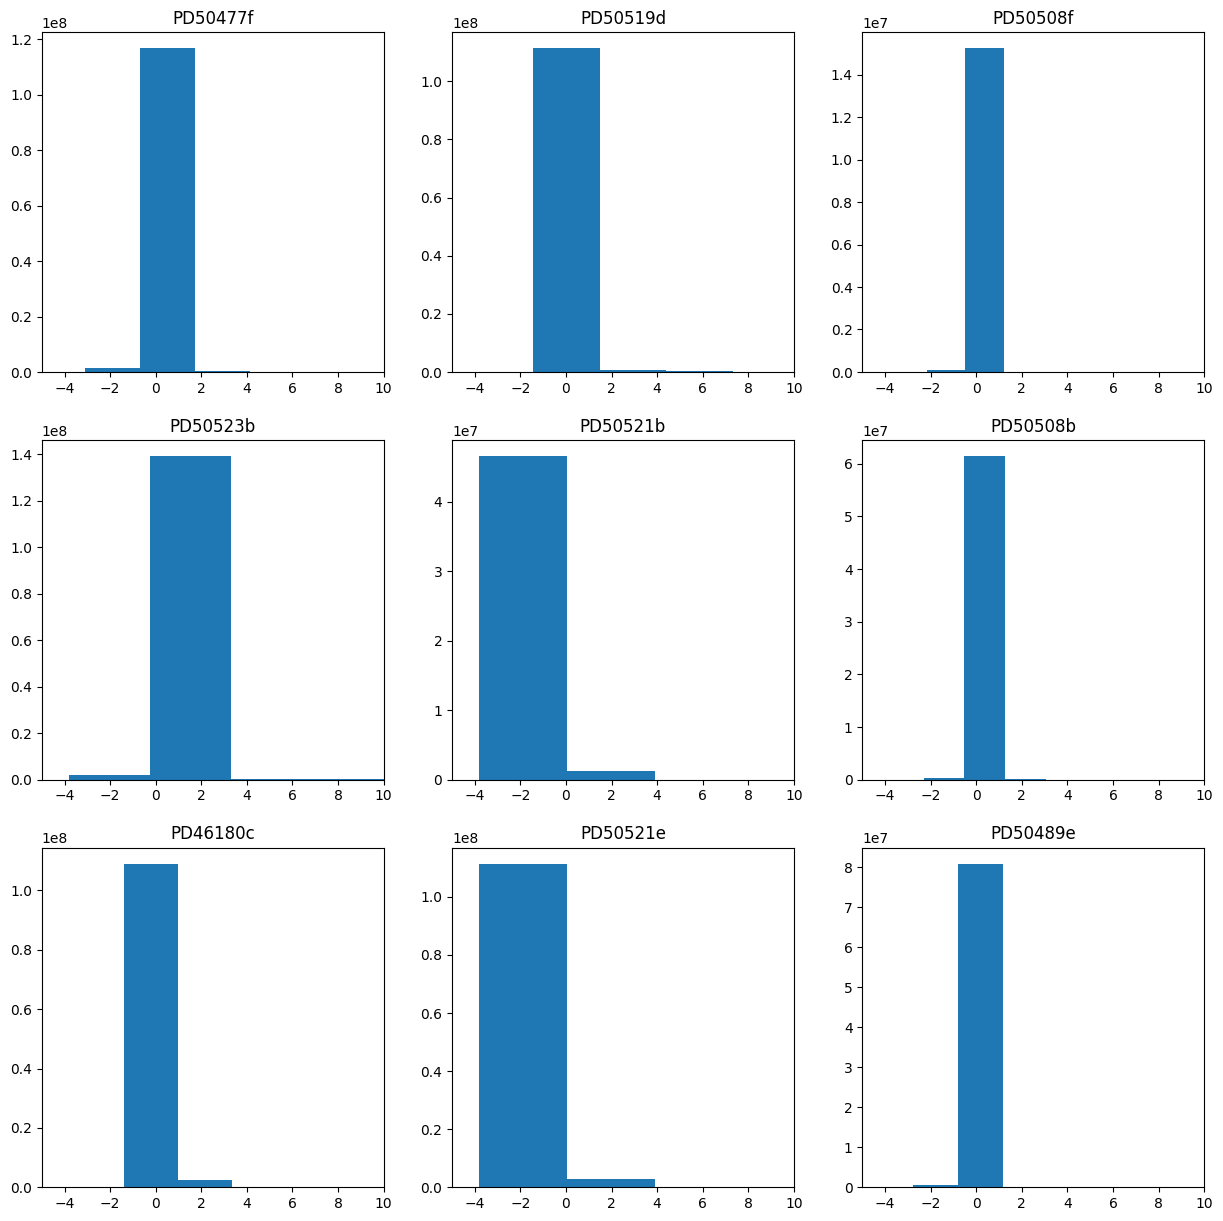

In [12]:
fig, axs = plt.subplots(3,3, figsize=(15, 15));

for sample_id, ax in zip(rahbari_sample_ids, axs.ravel()):
    sub = hist_unassigned.filter(pl.col("sample_id") == sample_id)
    
    x = []
    w = []
    for n, L in zip(sub["unassigned_reads"], sub["len"]):
        x.append(n)
        w.append(L)
   
    ax.hist(
        x=x, weights=w, bins=50,
    );
#    ax.axvline(0.5, color="black");
    ax.set_title(sample_id);
    ax.set_xlim(-5,10);


    

### Some debugging

In [13]:
%%time

output_path = Path("/lustre/scratch122/tol/projects/sperm/results/Rahbari_20250212")

snps_df = pl.scan_parquet([
    str(output_path / f"read_analysis/PD46180c/PD46180c/{R['flow_cell']}/chr5/" \
                / "annotated_0.95_high_confidence_snps.parquet")
            for R in rahbari_df.iter_rows(named=True) if R["sample_id"] == "PD46180c" #and R["flow_cell_type"] == "revio_unbinned"
]).collect()

CPU times: user 6.89 s, sys: 5.33 s, total: 12.2 s
Wall time: 5.22 s


In [14]:
all_reads_df = pl.scan_parquet([
    str(output_path / f"read_analysis/{sample_set}/{sample_id}/reads/chr5/all_reads_structure_annotated.parquet") 
     for sample_id, sample_set in tqdm.tqdm(rahbari_df.select("sample_id", "sample_set").unique().iter_rows())
])

9it [00:00, 37264.30it/s]


In [15]:
non_assigned_reads_df = (all_reads_df
    .select("read_name", pl.col("idx_transitions").list.len().alias("n_transitions"), "class")
    .filter(pl.col("n_transitions") > 0)
)

In [16]:
fnames = [
    (
        str(output_path / f"alignments/{R['sample_set']}/{R['sample_id']}/{R['flow_cell']}/T2T_reference/" \
                    / "minimap2.sorted.primary_alignments.ref_starts.csv.gz")
    )
            for R in rahbari_df.iter_rows(named=True)
]

In [23]:
read_name_to_flow_cell_df = pl.concat([
    (
        pl.scan_csv(
            str(output_path / f"alignments/{R['sample_set']}/{R['sample_id']}/{R['flow_cell']}/T2T_reference/" \
                    / "minimap2.sorted.primary_alignments.ref_starts.csv.gz"),
            has_header=False,
            separator=',',
        )
        .rename({f"column_{i+1}": name for i, name in enumerate(["read_name", "chrom", "pos"])})            
        .with_columns(
            sample_set = pl.lit(R['sample_set']),
            sample_id = pl.lit(R['sample_id']),
            flow_cell = pl.lit(R['flow_cell']),
        )
        .select("read_name", "sample_set", "sample_id", "flow_cell")
    )
            for R in list(rahbari_df.iter_rows(named=True))
])

In [18]:
%%time
unassigned_reads_flow_cell_stats_df = (ann_snps_df
    .filter((pl.col("hap1_total_coverage") == pl.col("hap2_total_coverage")))
    .with_columns(
         unassigned_reads = (pl.col("hap1_total_coverage") - pl.col("hap1_certainty_0.95_coverage") - pl.col("hap2_certainty_0.95_coverage"))
    )
    .filter(pl.col("unassigned_reads") > 1)
    .join(non_assigned_reads_df, on="read_name")
    .join(read_name_to_flow_cell_df, on="read_name")
    .select("sample_set", "sample_id", "read_name", "flow_cell")
    .group_by("sample_set", "sample_id", "flow_cell").len()
    .collect(streaming=True)
)

CPU times: user 7min 48s, sys: 1min 24s, total: 9min 13s
Wall time: 2min 41s


In [19]:
with pl.Config(tbl_rows=100):
    display(unassigned_reads_flow_cell_stats_df.sort("sample_set", "sample_id"))

sample_set,sample_id,flow_cell,len
str,str,str,u32
"""PD46180c""","""PD46180c""","""m84047_241008_114208_s4""",126
"""PD46180c""","""PD46180c""","""m84047_241008_110952_s3""",122
"""PD46180c""","""PD46180c""","""m64094e_220916_121850""",76
"""PD46180c""","""PD46180c""","""m64178e_220824_153720""",57
"""PD46180c""","""PD46180c""","""m84047_240928_140551_s1""",268
"""PD46180c""","""PD46180c""","""m84047_240924_103047_s2""",99
"""PD46180c""","""PD46180c""","""m64016e_220904_102424""",83
"""PD50477f""","""PD50477f""","""m84047_241008_100605_s1""",710
"""PD50477f""","""PD50477f""","""m64178e_220829_002441""",166


In [67]:
rahbari_df

sample_set,sample_id,flow_cell,flow_cell_type,path
str,str,str,str,str
"""PD50521b_PD50521e""","""PD50521b""","""m84093_241012_145529_s3""","""revio_40""","""/lustre/scratch122/tol/project…"
"""PD50521b_PD50521e""","""PD50521b""","""m84047_240924_113521_s4""","""revio_unbinned""","""/lustre/scratch122/tol/project…"
"""PD50521b_PD50521e""","""PD50521b""","""m64178e_240721_224443""","""sequel_ii""","""/lustre/scratch122/tol/project…"
"""PD50521b_PD50521e""","""PD50521b""","""m64229e_220912_125215""","""sequel_ii""","""/lustre/scratch122/tol/project…"
"""PD50521b_PD50521e""","""PD50521b""","""m64016e_220901_135237""","""sequel_ii""","""/lustre/scratch122/tol/project…"
…,…,…,…,…
"""PD46180c""","""PD46180c""","""m64178e_220824_153720""","""sequel_ii""","""/lustre/scratch122/tol/project…"
"""PD46180c""","""PD46180c""","""m64016e_220904_102424""","""sequel_ii""","""/lustre/scratch122/tol/project…"
"""PD46180c""","""PD46180c""","""m64094e_220916_121850""","""sequel_ii""","""/lustre/scratch122/tol/project…"


In [6]:
%%time
hc_snps_df = pl.read_parquet(
    "/lustre/scratch122/tol/projects/sperm/results/CEPH_20250212/read_analysis/NA12881/NA12881/m84046_230401_043753_s1/chr9/high_confidence_snps.parquet"
)

CPU times: user 479 ms, sys: 577 ms, total: 1.06 s
Wall time: 1.54 s


In [12]:
hc_snps_df.head()

start,end,length,op1,op2,ref1_start,ref1_end,ref1_gap,ref2_start,ref2_end,ref2_gap,cigar_ptr1,cigar_ptr2,read_name,read_length1,read_length2,is_forward1,mapq1,ref1_name,qual_start1,refseq_start1,is_forward2,mapq2,ref2_name,qual_start2,refseq_start2,total_mismatches,total_common_insertions,num_common_insertions,num_common_deletions,total_clipping,num_clipping,is_snp,is_two_sided_mismatch,is_interesting_event,is_flanked_event,fits1_more,trf_repeat_length_hap1,trf_n_copies_hap1,trf_repeat_length_hap2,trf_n_copies_hap2,sdust_repeat_length_hap1,sdust_repeat_length_hap2,is_high_conf_event,is_high_conf_snp,is_mid_conf_event,is_mid_conf_snp
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i32,i32,bool,i32,str,u8,str,bool,i32,str,u8,str,i64,i64,u32,u32,i64,u32,bool,bool,bool,bool,i32,i64,f64,i64,f64,i32,i32,bool,bool,bool,bool
502,503,1,8,7,59917986,59917987,1,57067977,57067978,1,7,4,"""m84046_230401_043753_s1/238748…",18483,18483,false,46,"""chr9_RagTag""",40,"""C""",false,51,"""chr9_RagTag""",40,"""T""",0,2,2,8,7,1,true,false,true,true,0,0,0.0,0,0.0,0,0,false,false,true,true
560,561,1,8,7,59918044,59918045,1,57068035,57068036,1,9,4,"""m84046_230401_043753_s1/238748…",18483,18483,false,46,"""chr9_RagTag""",40,"""A""",false,51,"""chr9_RagTag""",40,"""G""",0,2,2,8,7,1,true,false,true,true,0,0,0.0,0,0.0,0,0,false,false,true,true
728,729,1,8,7,59918212,59918213,1,57068203,57068204,1,11,4,"""m84046_230401_043753_s1/238748…",18483,18483,false,46,"""chr9_RagTag""",40,"""A""",false,51,"""chr9_RagTag""",40,"""G""",0,2,2,8,7,1,true,false,true,true,0,0,0.0,0,0.0,0,0,false,false,true,true
975,976,1,8,7,59918459,59918460,1,57068450,57068451,1,13,4,"""m84046_230401_043753_s1/238748…",18483,18483,false,46,"""chr9_RagTag""",40,"""A""",false,51,"""chr9_RagTag""",40,"""G""",0,2,2,8,7,1,true,false,true,true,0,0,0.0,0,0.0,0,0,false,false,true,true
1401,1402,1,8,7,59918886,59918887,1,57068877,57068878,1,17,6,"""m84046_230401_043753_s1/238748…",18483,18483,false,46,"""chr9_RagTag""",40,"""C""",false,51,"""chr9_RagTag""",40,"""T""",0,2,2,8,7,1,true,false,true,true,0,24,2.4,24,2.5,0,0,false,false,false,false


In [25]:
hc_snps_df.group_by(pl.col("qual_start2")).len()

qual_start2,len
u8,u32
22,41609
17,46003
3,38909
10,51648
40,1003183
35,151932
27,52019


In [34]:
import yaml

config = yaml.safe_load(open("/nfs/users/nfs_r/rs42/rs42/git/sperm/configs/CEPH.yaml"))

In [48]:
# Parse data table
data_df = pd.read_csv(config["data_table_path"], sep="\s+", header=0, index_col=False, dtype=str)

# Sample sets to work on
if "sample_sets" in config.keys():
    sample_sets = str(config["sample_sets"]).split(",")
    data_df = data_df[data_df["sample_set"].isin(sample_sets)]
else:
    sample_sets = list(data_df["sample_set"].unique())

# Convenience dicts and lists
data_rows = list(data_df.itertuples())

flow_cell_to_path = {R.flow_cell:R.path for R in data_rows}
flow_cell_to_type = {R.flow_cell:R.flow_cell_type for R in data_rows}

flow_cell_to_params = {}
for R in data_rows:    
    flow_cell_to_params[R.flow_cell] = config["qc_parameters"].copy()
    flow_cell_to_params[R.flow_cell].update(config["flow_cell_types"][R.flow_cell_type])
    print(R.flow_cell, R.flow_cell_type, flow_cell_to_params[R.flow_cell]["base_qual_min_detection"])


m84039_230401_021407_s1 revio_50 50
m84039_230403_233415_s1 revio_50 50
m84046_230515_211624_s3 revio_40 40
m84039_230304_020711_s3 revio_50 50
m84039_230317_185953_s3 revio_50 50
m84046_230329_185756_s1 revio_40 40
m84046_230401_040731_s4 revio_40 40
m84046_230401_043753_s1 revio_40 40
m84046_230403_202554_s4 revio_40 40
m64076_230326_080926 sequel_ii 60
m64076_230327_174311 sequel_ii 60
m64076_230324_223402 sequel_ii 60
m54329U_230203_125016 sequel_ii 60
m64076_230409_033653 sequel_ii 60
m64076_230125_193523 sequel_ii 60
m64076_230405_190254 sequel_ii 60
m54329U_230204_220457 sequel_ii 60
m64076_230407_182249 sequel_ii 60
m54329U_230131_182014 sequel_ii 60
m54329U_230202_033258 sequel_ii 60
m64076_230329_031008 sequel_ii 60
m54329U_230314_044350 sequel_ii 60
m54329U_230312_191124 sequel_ii 60
m54329U_230311_094504 sequel_ii 60
m84046_230522_231536_s1 revio_40 40
m84039_230320_220725_s4 revio_50 50
m84046_230512_221707_s2 revio_40 40
m84039_230305_012045_s2 revio_50 50
m84039_230401_0

In [49]:
flow_cell_to_type["m84046_230401_043753_s1"]

'revio_40'

In [50]:
flow_cell_to_params["m84046_230401_043753_s1"]

{'high_confidence_slack': 10,
 'certainty_threshold': 0.95,
 'map_qual_min': 60,
 'total_mismatches_max': 100,
 'total_clipping_max': 10,
 'phased_coverage_min': 3,
 'allele_coverage_min': 3,
 'GC_tract_mean': 30,
 'read_margin_in_bp': 5000,
 'balance_p_value_threshold': 0,
 'unassigned_reads_max': 10000,
 'base_qual_min_detection': 40,
 'base_qual_min_classification': 30,
 'read_trimming_detection': 400,
 'read_trimming_classification': 200}

In [26]:
hap_stats_df = diagnostics.snps_to_read_stats(
    hc_snps_df,
    pl.col("is_high_conf_snp"),
    "frac_fits1_more_snps_high_conf",
)

TypeError: snps_to_read_stats() got an unexpected keyword argument 'base_qual_min'

In [14]:
rahbari_df

sample_set,sample_id,flow_cell,flow_cell_type,path
str,str,str,str,str
"""PD50521b_PD50521e""","""PD50521b""","""m84047_240924_113521_s4""","""revio_unbinned""","""/lustre/scratch122/tol/project…"
"""PD50521b_PD50521e""","""PD50521b""","""m64178e_240721_224443""","""sequel_ii""","""/lustre/scratch122/tol/project…"
"""PD50521b_PD50521e""","""PD50521b""","""m64229e_220912_125215""","""sequel_ii""","""/lustre/scratch122/tol/project…"
"""PD50521b_PD50521e""","""PD50521b""","""m64016e_220901_135237""","""sequel_ii""","""/lustre/scratch122/tol/project…"
"""PD50521b_PD50521e""","""PD50521b""","""m64229e_220909_150132""","""sequel_ii""","""/lustre/scratch122/tol/project…"
…,…,…,…,…
"""PD46180c""","""PD46180c""","""m64178e_220824_153720""","""sequel_ii""","""/lustre/scratch122/tol/project…"
"""PD46180c""","""PD46180c""","""m64016e_220904_102424""","""sequel_ii""","""/lustre/scratch122/tol/project…"
"""PD46180c""","""PD46180c""","""m64094e_220916_121850""","""sequel_ii""","""/lustre/scratch122/tol/project…"


## BQ distribution

In [5]:
output_path = Path("/lustre/scratch122/tol/projects/sperm/results/Rahbari_20250212")

max_qual_stats_df = pl.concat([
    (
        pl.scan_parquet(glob.glob(str(
            output_path / f"read_analysis/{sample_set}/{sample_id}/{flow_cell}/*/annotated_0.95_high_confidence_snps.parquet"
        ))).with_columns(
            sample_id=pl.lit(sample_id), 
            flow_cell=pl.lit(flow_cell),
            flow_cell_type=pl.lit(flow_cell_type),        
        )
        .group_by("sample_id", "flow_cell", "flow_cell_type", "read_name")
        .agg(
            max_qual = pl.col("qual_start1").max(),
            min_qual = pl.col("qual_start1").min(),
            median_qual = pl.col("qual_start1").median(),
            chrom = pl.col("ref1_name").first(),
            ref1_start = pl.col("ref1_start").first(),
            ref2_start = pl.col("ref2_start").first(),
            n_snps = pl.len(),
        )
        .collect(streaming=True)
    )
    for sample_set, sample_id, flow_cell, flow_cell_type, _ in tqdm.tqdm(rahbari_df.iter_rows())
        if sample_id in ["PD50523b", "PD50477f"]
])


56it [02:32,  2.72s/it]


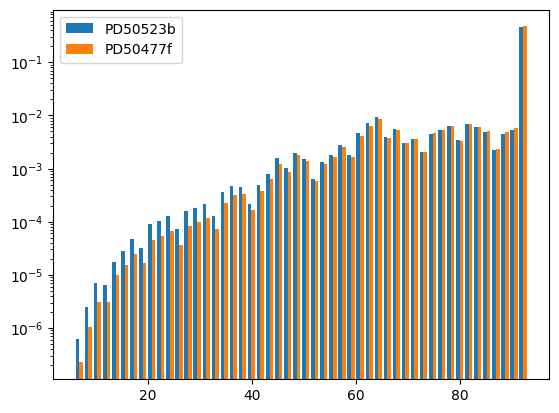

In [9]:
plt.hist(
    [
        max_qual_stats_df.filter((pl.col("n_snps") > 10) & (pl.col("sample_id") == "PD50523b"))["max_qual"], 
        max_qual_stats_df.filter((pl.col("n_snps") > 10) & (pl.col("sample_id") == "PD50477f"))["max_qual"], 
    ],
    bins=50,
    density=True,
    log=True,
);

plt.legend(["PD50523b", "PD50477f"]);

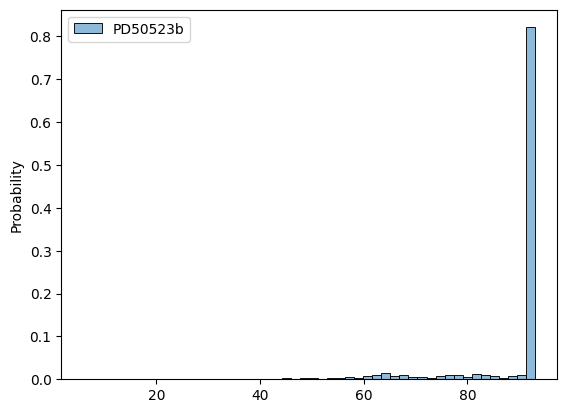

In [18]:
sns.histplot(
    [
        max_qual_stats_df.filter((pl.col("n_snps") > 10) & (pl.col("sample_id") == "PD50523b"))["max_qual"], 
        max_qual_stats_df.filter((pl.col("n_snps") > 10) & (pl.col("sample_id") == "PD50477f"))["max_qual"], 
    ],
    bins=50,
    stat="probability",
);

plt.legend(["PD50523b", "PD50477f"]);
#plt.ylim(0, 0.02);

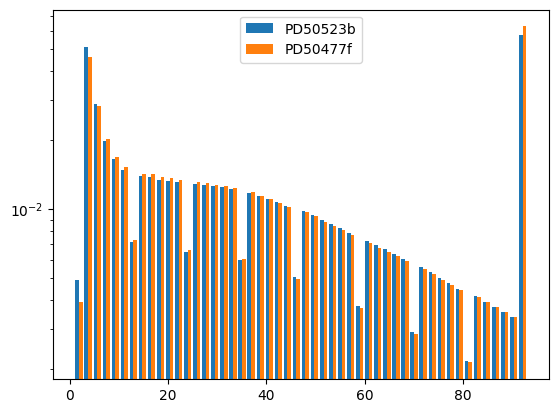

In [11]:
plt.hist(
    [
        max_qual_stats_df.filter((pl.col("n_snps") > 10) & (pl.col("sample_id") == "PD50523b"))["min_qual"], 
        max_qual_stats_df.filter((pl.col("n_snps") > 10) & (pl.col("sample_id") == "PD50477f"))["min_qual"], 
    ],
    bins=50,
    density=True,
    log=True,
);

plt.legend(["PD50523b", "PD50477f"]);

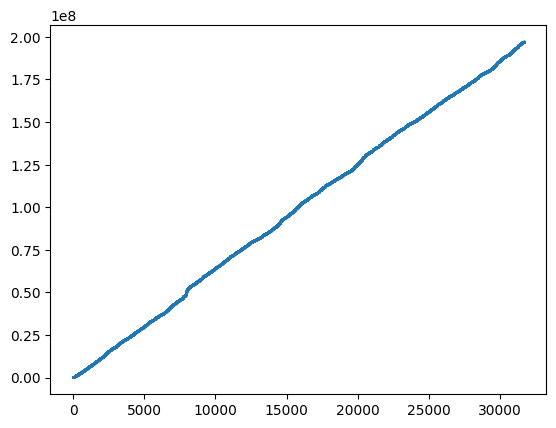

In [24]:
with pl.Config(tbl_rows=100):
    plt.plot(max_qual_stats_df
        .filter(
            (pl.col("n_snps") > 10) & (pl.col("sample_id") == "PD50523b") & (pl.col("max_qual") < 60) & (pl.col("chrom") == "chr3_RagTag")
        )
        .sort("ref1_start")["ref1_start"], '.', ms=1
    )

In [27]:
max_qual_stats_df.filter((pl.col("n_snps") > 10) & (pl.col("sample_id") == "PD50523b")).select(pl.col("max_qual") < 40).mean()

max_qual
f64
0.004351


In [28]:
max_qual_stats_df.filter((pl.col("n_snps") > 10) & (pl.col("sample_id") == "PD50477f")).select(pl.col("max_qual") < 40).mean()

max_qual
f64
0.002637
